In [1]:
%%capture
import torch

# 1. Unsloth'u Ana Paket Olarak Kur
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

# 2. KRİTİK ADIM: Xformers'ı Hazır Paket (Binary) Olarak Zorla Yükle
# Bu satır "Building wheels" hatasını engeller.
!pip install xformers --index-url https://download.pytorch.org/whl/cu121 --no-deps

# 3. Diğerlerini versiyon kontrolü yapmadan hızlıca kur
!pip install --no-deps "trl<0.9.0" peft accelerate bitsandbytes

In [2]:
# Gerekli Importlar
from unsloth import FastLanguageModel
from trl import SFTTrainer
from transformers import TrainingArguments
from datasets import load_dataset
import shutil
import os
from google.colab import drive

# 2. DRIVE BAĞLANTISI
print("📂 Google Drive bağlanıyor...")
drive.mount('/content/drive')

# ========================================================
# 1. DEĞİŞİKLİK: Dosya Yolu (Fizik İçin Ayarlandı)
# ========================================================
source_file = "/content/drive/MyDrive/Proje_Yedekleri/fizik_train.json"
local_file = "fizik_train.json"

# Dosyayı Çek
if os.path.exists(source_file):
    shutil.copy(source_file, local_file)
    print(f"✅ Fizik Verisi Drive'dan Alındı: {local_file}")
else:
    print(f"❌ HATA: '{source_file}' bulunamadı! Lütfen dosya adını kontrol et.")

# 3. MODELİ YÜKLE
max_seq_length = 2048
model_name = "unsloth/Meta-Llama-3.1-8B-bnb-4bit"

print(f"🔄 Model Yükleniyor: {model_name}...")
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    max_seq_length = max_seq_length,
    dtype = None,
    load_in_4bit = True,
)

# LoRA Ayarları (Merge uyumu için diğerleriyle BİREBİR AYNI)
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
)

# ========================================================
# 2. DEĞİŞİKLİK: Prompt ve Formatlama (Fizik İçin)
# ========================================================
prompt_template = """Aşağıdaki fizik sorusunu adım adım düşünerek çöz ve doğru seçeneği belirt.

### Soru:
{}

### Seçenekler:
{}

### Çözüm ve Cevap:
{}
Doğru Cevap: {}""" + tokenizer.eos_token

def formatting_prompts_func(examples):
    questions = examples["question"]
    options_lists = examples["options"]

    # Hata Önleyici: Fizik dosyasında 'rationale' yoksa boş geç
    if "rationale" in examples:
        rationales = examples["rationale"]
    else:
        rationales = [""] * len(questions)

    corrects = examples["correct"]
    texts = []

    for q, opts, rat, corr in zip(questions, options_lists, rationales, corrects):
        # Liste kontrolü (String mi Liste mi?)
        if not isinstance(opts, list):
            opts_str = str(opts) if opts is not None else ""
        else:
            try: opts_str = "\n".join([str(x) for x in opts])
            except: opts_str = str(opts)

        text = prompt_template.format(str(q), opts_str, str(rat), str(corr))
        texts.append(text)
    return { "text" : texts, }

print("♻️ Fizik Verisi Formatlanıyor...")
dataset = load_dataset("json", data_files={"train": local_file}, split="train")
dataset = dataset.map(formatting_prompts_func, batched = True)

# 5. EĞİTİMİ BAŞLAT
print("🚀 FİZİK EĞİTİMİ BAŞLIYOR (A100)...")

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        # --- A100 AYARLARI (Kimya ile Eşitlendi) ---
        per_device_train_batch_size = 16, # A100 Belleği geniş
        gradient_accumulation_steps = 1,  # 16x1 = 16 Effective Batch
        warmup_steps = 10,
        max_steps = 60, # Diğer modellerle aynı adım sayısı
        learning_rate = 2e-4,
        fp16 = False,
        bf16 = True, # A100 için BFloat16
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

trainer_stats = trainer.train()

# ========================================================
# 3. DEĞİŞİKLİK: Kayıt İsimleri
# ========================================================
save_name = "model_fizik_uzmani"
print(f"💾 Model kaydediliyor: {save_name}...")
model.save_pretrained(save_name)
tokenizer.save_pretrained(save_name)

# 7. DRIVE'A YEDEKLE
print("☁️ Drive'a Yedekleniyor...")
dest_path = f"/content/drive/MyDrive/Proje_Yedekleri/{save_name}"

if os.path.exists(dest_path):
    shutil.rmtree(dest_path) # Eskisi varsa sil
shutil.copytree(save_name, dest_path)

print(f"🎉 FİZİK MODELİ HAZIR: {dest_path}")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Unsloth: Could not import trl.trainer.ddpo_trainer: Failed to import trl.trainer.ddpo_trainer because of the following error (look up to see its traceback):
Failed to import trl.models.modeling_sd_base because of the following error (look up to see its traceback):
Failed to import diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion because of the following error (look up to see its traceback):
Failed to import diffusers.loaders.ip_adapter because of the following error (look up to see its traceback):
JITCallable._set_src() takes 1 positional argument but 2 were given
📂 Google Drive bağlanıyor...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Fizik Verisi Drive'dan Alındı: fizik_train.json
🔄 Model Yükleniyor: unsloth/Meta-Llama-3.1-8B-bnb-4bit...
==((====))=

model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/235 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

Unsloth 2026.1.4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


♻️ Fizik Verisi Formatlanıyor...


Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

🚀 FİZİK EĞİTİMİ BAŞLIYOR (A100)...


Map (num_proc=2):   0%|          | 0/400 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 400 | Num Epochs = 3 | Total steps = 60
O^O/ \_/ \    Batch size per device = 16 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (16 x 1 x 1) = 16
 "-____-"     Trainable parameters = 41,943,040 of 8,072,204,288 (0.52% trained)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yebalta86 (yebalta86-y-ld-z-technical-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Detected [openai] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.621300
2,1.623500
3,1.665600
4,1.620800
5,1.610500
6,1.601300
7,1.404500
8,1.215500
9,1.150600
10,1.131300


💾 Model kaydediliyor: model_fizik_uzmani...
☁️ Drive'a Yedekleniyor...
🎉 FİZİK MODELİ HAZIR: /content/drive/MyDrive/Proje_Yedekleri/model_fizik_uzmani


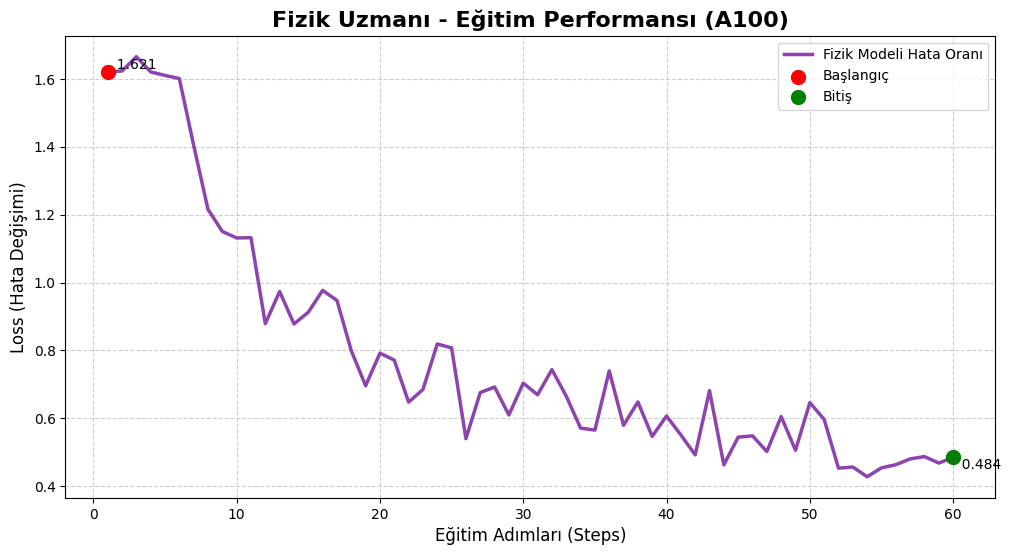

✅ Grafik başarıyla kaydedildi: /content/drive/MyDrive/Proje_Yedekleri/Fizik_Egitim_Analizi.png

🔍 GRAFİK YORUMU:
📉 Hata oranı 1.621 seviyesinden 0.484 seviyesine düşmüş.
🌟 MÜKEMMEL: Model veri setini çok iyi öğrenmiş.


In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Eğitim verilerini (Logları) çek
history = trainer.state.log_history

# Sadece 'loss' değeri olan adımları filtrele
loss_data = [{'step': x['step'], 'loss': x['loss']} for x in history if 'loss' in x]
df = pd.DataFrame(loss_data)

# 2. Grafik Çizimi
plt.figure(figsize=(12, 6))

# Çizgi grafiği
plt.plot(df['step'], df['loss'], label='Fizik Modeli Hata Oranı', color='#8e44ad', linewidth=2.5)

# Başlangıç ve Bitiş noktalarını işaretle
if not df.empty:
    start_loss = df.iloc[0]['loss']
    end_loss = df.iloc[-1]['loss']

    plt.scatter(df.iloc[0]['step'], start_loss, color='red', s=100, zorder=5, label='Başlangıç')
    plt.text(df.iloc[0]['step'], start_loss, f'  {start_loss:.3f}', verticalalignment='bottom')

    plt.scatter(df.iloc[-1]['step'], end_loss, color='green', s=100, zorder=5, label='Bitiş')
    plt.text(df.iloc[-1]['step'], end_loss, f'  {end_loss:.3f}', verticalalignment='top')

# Tasarım detayları
plt.title('Fizik Uzmanı - Eğitim Performansı (A100)', fontsize=16, fontweight='bold')
plt.xlabel('Eğitim Adımları (Steps)', fontsize=12)
plt.ylabel('Loss (Hata Değişimi)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# 3. Grafiği Drive'a Kaydet
grafik_yolu = "/content/drive/MyDrive/Proje_Yedekleri/Fizik_Egitim_Analizi.png"
plt.savefig(grafik_yolu, dpi=300)
plt.show()

print(f"✅ Grafik başarıyla kaydedildi: {grafik_yolu}")

# 4. Yorumlayıcı
print("\n🔍 GRAFİK YORUMU:")
print(f"📉 Hata oranı {start_loss:.3f} seviyesinden {end_loss:.3f} seviyesine düşmüş.")

if end_loss < 0.8:
    print("🌟 MÜKEMMEL: Model veri setini çok iyi öğrenmiş.")
elif end_loss < 1.2:
    print("✅ İYİ: Model konuyu kavramış, kullanılabilir durumda.")
else:
    print("⚠️ GELİŞTİRİLMELİ: Model hala zorlanıyor, daha fazla veri veya adım gerekebilir.")

📚 100 adet Fizik test sorusu yüklendi.
🚀 Test Başlıyor (Toplam 100 Soru)...


Fizik Testi: 100%|██████████| 7/7 [01:22<00:00, 11.72s/it]



🏆 FİZİK TEST SONUCU: %44.00
💾 Detaylı rapor kaydedildi: /content/drive/MyDrive/Proje_Yedekleri/Fizik_Test_Detaylari.xlsx


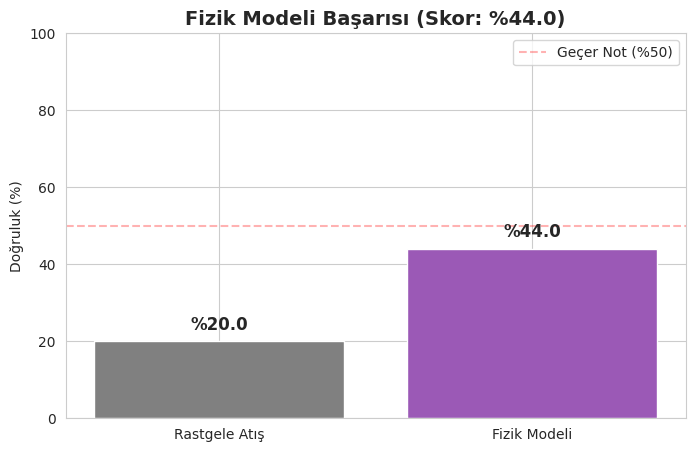

In [4]:
import torch
from unsloth import FastLanguageModel
import json
from tqdm import tqdm
import re
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# 1. TEST VERİSİNİ YÜKLE
test_path = "/content/drive/MyDrive/Proje_Yedekleri/fizik_test.json"

if not os.path.exists(test_path):
    print(f"❌ HATA: Test dosyası bulunamadı: {test_path}")
    # Eğer test dosyası yoksa örnek bir veriyle devam edemeyiz, durduruyoruz.
    test_data = []
else:
    with open(test_path, 'r', encoding='utf-8') as f:
        test_data = json.load(f)
    print(f"📚 {len(test_data)} adet Fizik test sorusu yüklendi.")

# 2. YARDIMCI FONKSİYONLAR
def extract_answer(text):
    # Modelin cevabından A, B, C, D, E harfini yakalar
    match = re.search(r"Doğru Cevap:\s*([A-E])", text, re.IGNORECASE)
    if match: return match.group(1).upper()
    return "Boş"

def run_test_turbo(model, tokenizer, data):
    FastLanguageModel.for_inference(model) # Inference modunu aç (Hızlandırır)

    BATCH_SIZE = 16 # A100 için
    correct = 0
    results = []

    print(f"🚀 Test Başlıyor (Toplam {len(data)} Soru)...")

    # Prompt Şablonu (Eğitimdeki ile aynı olmalı)
    prompt_temp = """Aşağıdaki fizik sorusunu çöz.

### Soru:
{}

### Seçenekler:
{}

### Çözüm ve Cevap:
""" # Cevap kısmı boş bırakılır ki model tamamlasın

    # Veriyi gruplara ayır (Batching)
    batches = [data[i:i + BATCH_SIZE] for i in range(0, len(data), BATCH_SIZE)]

    for batch in tqdm(batches, desc="Fizik Testi"):
        texts = []
        truths = []
        q_texts = []

        for item in batch:
            q = item.get("question")
            opts = item.get("options")
            opts_str = "\n".join([str(x) for x in opts]) if isinstance(opts, list) else str(opts)
            truth = str(item.get("correct")).strip().upper()

            texts.append(prompt_temp.format(q, opts_str))
            truths.append(truth)
            q_texts.append(q)

        # GPU'ya Toplu Gönder
        inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to("cuda")

        # Üretim Yap
        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=128, use_cache=True)

        decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        # Sonuçları Kontrol Et
        for i, text in enumerate(decoded):
            # Prompt kısmını at, sadece modelin ürettiği cevaba bak
            gen_text = text.replace(texts[i], "")
            ans = extract_answer(gen_text)

            is_correct = (ans == truths[i])
            if is_correct: correct += 1

            results.append({
                "Soru": q_texts[i][:60] + "...",
                "Gerçek Cevap": truths[i],
                "Model Tahmini": ans,
                "Durum": "✅ Doğru" if is_correct else "❌ Yanlış"
            })

    accuracy = (correct / len(data)) * 100
    return accuracy, results

# 3. TESTİ ÇALIŞTIR
if test_data:
    acc, res_list = run_test_turbo(model, tokenizer, test_data)

    print(f"\n🏆 FİZİK TEST SONUCU: %{acc:.2f}")

    # 4. SONUÇLARI KAYDET
    df_res = pd.DataFrame(res_list)
    excel_path = "/content/drive/MyDrive/Proje_Yedekleri/Fizik_Test_Detaylari.xlsx"
    df_res.to_excel(excel_path, index=False)
    print(f"💾 Detaylı rapor kaydedildi: {excel_path}")

    # 5. GRAFİK ÇİZ
    plt.figure(figsize=(8, 5))
    sns.set_style("whitegrid")

    # Veriler
    categories = ['Rastgele Atış', 'Fizik Modeli']
    scores = [20, acc] # 5 şık olduğu için rastgele başarı %20'dir
    colors = ['gray', '#9b59b6']

    bars = plt.bar(categories, scores, color=colors)
    plt.title(f'Fizik Modeli Başarısı (Skor: %{acc:.1f})', fontsize=14, fontweight='bold')
    plt.ylabel('Doğruluk (%)')
    plt.ylim(0, 100)

    # Değerleri yaz
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, height + 2, f'%{height:.1f}',
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.axhline(y=50, color='r', linestyle='--', alpha=0.3, label='Geçer Not (%50)')
    plt.legend()

    plt.savefig("/content/drive/MyDrive/Proje_Yedekleri/Fizik_Basari_Grafigi.png")
    plt.show()

else:
    print("⚠️ Test edilecek veri bulunamadı.")

📂 Dosya yüklendi: 100 kayıt bulundu.

❌ Toplam Yanlış Sayısı: 56
📌 SORU (Sıra: 25):
Aralarında 0.20 m bulunan iki eşit noktasal yükün her biri +......
------------------------------------------------
✅ Gerçek Cevap: C
🤖 Modelin Tahmini: Boş

📌 SORU (Sıra: 41):
Bir araç 20 m/s sabit hızla giderken önündeki engeli görüp 4......
------------------------------------------------
✅ Gerçek Cevap: C
🤖 Modelin Tahmini: Boş

📌 SORU (Sıra: 49):
Derinliği her yerde aynı olan bir dalga leğeninde, aynı fazd......
------------------------------------------------
✅ Gerçek Cevap: A
🤖 Modelin Tahmini: C

📌 SORU (Sıra: 97):
Hava iletkenliği ihmal edilerek, birbirinden çok uzakta iki ......
------------------------------------------------
✅ Gerçek Cevap: D
🤖 Modelin Tahmini: Boş

📌 SORU (Sıra: 82):
12 V'luk ideal kaynağa bağlı devrede, 4 Ω direnç seri; onun ......
------------------------------------------------
✅ Gerçek Cevap: C
🤖 Modelin Tahmini: Boş



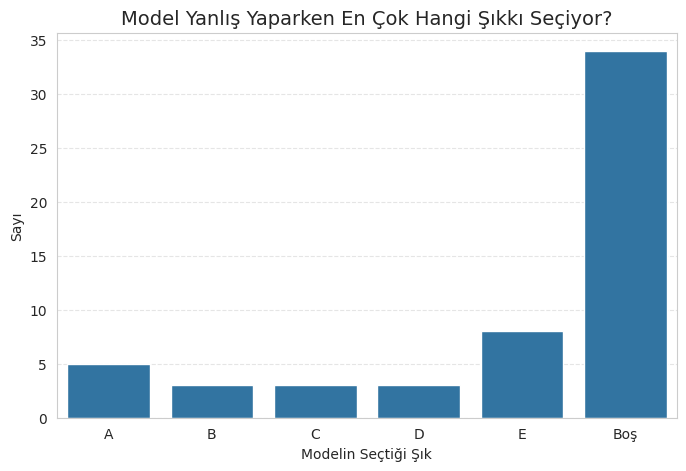

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. Test Sonuçlarını Yükle
excel_path = "/content/drive/MyDrive/Proje_Yedekleri/Fizik_Test_Detaylari.xlsx"

if os.path.exists(excel_path):
    df = pd.read_excel(excel_path)
    print(f"📂 Dosya yüklendi: {len(df)} kayıt bulundu.")

    # 2. Yanlış Cevapları Filtrele
    yanlislar = df[df["Durum"] == "❌ Yanlış"]

    print(f"\n❌ Toplam Yanlış Sayısı: {len(yanlislar)}")
    print("="*60)

    # 3. Örnek 5 Hatalı Soruyu Göster
    # Rastgele 5 tanesini seçelim (Eğer 5'ten az ise hepsini)
    sample_size = min(5, len(yanlislar))
    ornekler = yanlislar.sample(sample_size)

    for index, row in ornekler.iterrows():
        print(f"📌 SORU (Sıra: {index+1}):")
        print(f"{row['Soru']}...") # Sorunun ilk kısmı
        print(f"------------------------------------------------")
        print(f"✅ Gerçek Cevap: {row['Gerçek Cevap']}")
        print(f"🤖 Modelin Tahmini: {row['Model Tahmini']}")
        print("="*60 + "\n")

    # 4. Modelin Yanlış Eğilimini Analiz Et (Grafik)
    # Model yanlış yaparken en çok hangi şıkkı seçiyor?
    plt.figure(figsize=(8, 5))
    sns.countplot(x=yanlislar['Model Tahmini'], order=['A', 'B', 'C', 'D', 'E', 'Boş'])
    plt.title('Model Yanlış Yaparken En Çok Hangi Şıkkı Seçiyor?', fontsize=14)
    plt.xlabel('Modelin Seçtiği Şık')
    plt.ylabel('Sayı')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

else:
    print("⚠️ HATA: Test sonuç dosyası bulunamadı. Lütfen önce testi çalıştırın.")

In [6]:
import torch
from unsloth import FastLanguageModel
import json
from tqdm import tqdm
import re
import pandas as pd
import os

# 1. Gelişmiş Cevap Yakalayıcı
def extract_answer_robust(text):
    # 1. Yöntem: Standart kalıp (En güvenlisi)
    match = re.search(r"Doğru Cevap:\s*([A-E])", text, re.IGNORECASE)
    if match: return match.group(1).upper()

    # 2. Yöntem: "Cevap: A" veya "Seçenek: A" gibi varyasyonlar
    match = re.search(r"(?:Cevap|Seçenek|Yanıt)[:\s-]*([A-E])", text, re.IGNORECASE)
    if match: return match.group(1).upper()

    # 3. Yöntem: Metnin EN SONUNDAKİ tek harfi yakala (Umutsuz durumlar için)
    # Genelde model çözüm yapıp en sona "A" yazar.
    clean_text = text.strip()
    if len(clean_text) > 0:
        last_char = clean_text[-1].upper()
        if last_char in ['A', 'B', 'C', 'D', 'E']:
            return last_char

    return "Boş"

# 2. Güncellenmiş Test Fonksiyonu
def run_test_fixed(model, tokenizer, data):
    FastLanguageModel.for_inference(model)

    BATCH_SIZE = 16
    correct = 0
    results = []
    empty_count = 0

    print(f"🚀 Test Tekrar Başlıyor (Limit Artırıldı)...")

    # Prompt Şablonu
    prompt_temp = """Aşağıdaki fizik sorusunu çöz.

### Soru:
{}

### Seçenekler:
{}

### Çözüm ve Cevap:
"""

    batches = [data[i:i + BATCH_SIZE] for i in range(0, len(data), BATCH_SIZE)]

    for batch in tqdm(batches, desc="Fizik Testi (v2)"):
        texts = []
        truths = []
        q_texts = []

        for item in batch:
            q = item.get("question")
            opts = item.get("options")
            opts_str = "\n".join([str(x) for x in opts]) if isinstance(opts, list) else str(opts)
            truth = str(item.get("correct")).strip().upper()

            texts.append(prompt_temp.format(q, opts_str))
            truths.append(truth)
            q_texts.append(q)

        inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to("cuda")

        # --- DÜZELTME BURADA ---
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=512,  # <--- 128 yerine 512 yaptık. Fizik işlemi uzun sürer!
                use_cache=True,
                pad_token_id=tokenizer.eos_token_id
            )

        decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        for i, text in enumerate(decoded):
            # Sadece üretilen kısmı al
            gen_text = text.replace(texts[i], "").strip()

            # Yeni Robust Fonksiyonu Kullan
            ans = extract_answer_robust(gen_text)

            if ans == "Boş":
                empty_count += 1
                # Debug: Neden boş döndü? (İlk 3 tanesini yazdıralım)
                if empty_count <= 3:
                    print(f"\n⚠️ BOŞ CEVAP DETAYI:")
                    print(f"Model Çıktısı (Son 100 karakter): ...{gen_text[-100:]}")

            is_correct = (ans == truths[i])
            if is_correct: correct += 1

            results.append({
                "Soru": q_texts[i][:50],
                "Gerçek": truths[i],
                "Tahmin": ans,
                "Durum": "✅" if is_correct else "❌"
            })

    accuracy = (correct / len(data)) * 100
    print(f"\n⚠️ Toplam 'Boş' Cevap Sayısı: {empty_count} (Eskiden %33 idi)")
    return accuracy, results

# 3. Çalıştır
test_path = "/content/drive/MyDrive/Proje_Yedekleri/fizik_test.json"
if os.path.exists(test_path):
    with open(test_path, 'r') as f: test_data = json.load(f)

    acc, res = run_test_fixed(model, tokenizer, test_data)
    print(f"\n🏆 GÜNCELLENMİŞ SKOR: %{acc:.2f}")
else:
    print("Dosya yok.")

🚀 Test Tekrar Başlıyor (Limit Artırıldı)...


Fizik Testi (v2):  29%|██▊       | 2/7 [01:10<03:04, 36.98s/it]


⚠️ BOŞ CEVAP DETAYI:
Model Çıktısı (Son 100 karakter): ... sıcaklık artar: ΔT_su = 0°C'den m_buz*L_erime / m_su*c_su kadar. Erime tam tamamlanır: m_buz = m_su


Fizik Testi (v2):  43%|████▎     | 3/7 [01:56<02:44, 41.17s/it]


⚠️ BOŞ CEVAP DETAYI:
Model Çıktısı (Son 100 karakter): ... yok. Cevap seçenekleri menzil formülüne göre hesaplanmadı. Yatay bileşen: v0*cosθ = 30*0.8 = 24 m/s


Fizik Testi (v2):  57%|█████▋    | 4/7 [02:42<02:09, 43.05s/it]


⚠️ BOŞ CEVAP DETAYI:
Model Çıktısı (Son 100 karakter): ...g·m/s^2 / s^2 = kg·m/s^2 / s^2 = kg·m/s^2 / s^2 = kg·m/s^2 / s^2 = kg·m/s^2 / s^2 = kg·m/s^2 / s^2 =


Fizik Testi (v2): 100%|██████████| 7/7 [03:38<00:00, 31.23s/it]


⚠️ Toplam 'Boş' Cevap Sayısı: 3 (Eskiden %33 idi)

🏆 GÜNCELLENMİŞ SKOR: %54.00


💾 Excel Raporu Kaydedildi: /content/drive/MyDrive/Proje_Yedekleri/Fizik_Final_Test_Sonuclari.xlsx


/tmp/ipython-input-956968873.py:35: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(grafik1_path, dpi=300)
/tmp/ipython-input-956968873.py:35: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(grafik1_path, dpi=300)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


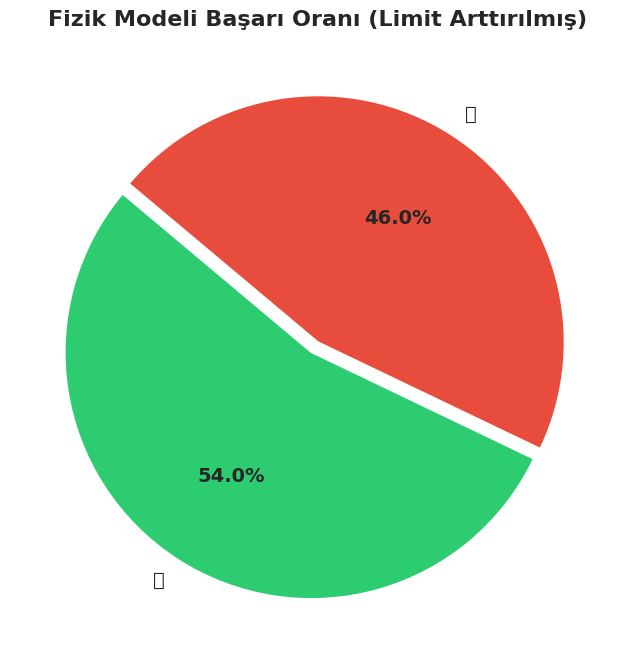

/tmp/ipython-input-956968873.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Tahmin', data=df_results, order=order_list, palette="viridis")


✅ Başarı Grafiği Kaydedildi: /content/drive/MyDrive/Proje_Yedekleri/Fizik_Basari_Pastasi.png


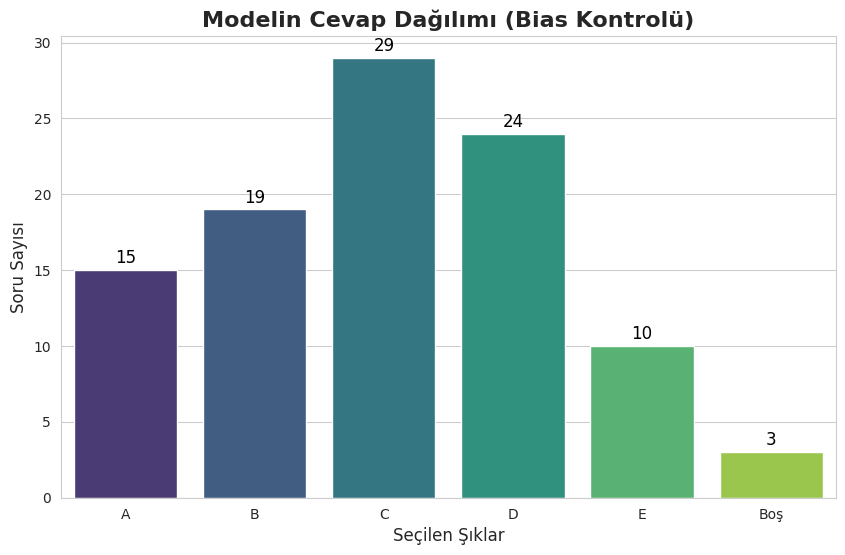

✅ Şık Dağılım Grafiği Kaydedildi: /content/drive/MyDrive/Proje_Yedekleri/Fizik_Sik_Dagilimi.png


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. Veriyi Hazırla (Önceki adımdaki 'res' listesini kullanıyoruz)
if 'res' in locals() and res:
    df_results = pd.DataFrame(res)

    # Kayıt Yolları
    save_folder = "/content/drive/MyDrive/Proje_Yedekleri"
    excel_path = f"{save_folder}/Fizik_Final_Test_Sonuclari.xlsx"
    grafik1_path = f"{save_folder}/Fizik_Basari_Pastasi.png"
    grafik2_path = f"{save_folder}/Fizik_Sik_Dagilimi.png"

    # 2. Excel Olarak Kaydet
    df_results.to_excel(excel_path, index=False)
    print(f"💾 Excel Raporu Kaydedildi: {excel_path}")

    # -------------------------------------------------------
    # GRAFİK 1: BAŞARI ORANI (PASTA GRAFİĞİ)
    # -------------------------------------------------------
    plt.figure(figsize=(8, 8))

    # Doğru/Yanlış Sayıları
    counts = df_results['Durum'].value_counts()

    # Renkler (Doğru: Yeşil, Yanlış: Kırmızı)
    colors = ['#2ecc71', '#e74c3c'] if '✅' in counts.index and '❌' in counts.index else None

    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=colors,
            textprops={'fontsize': 14, 'weight': 'bold'}, explode=(0.05, 0))

    plt.title(f"Fizik Modeli Başarı Oranı (Limit Arttırılmış)", fontsize=16, fontweight='bold')
    plt.savefig(grafik1_path, dpi=300)
    plt.show()
    print(f"✅ Başarı Grafiği Kaydedildi: {grafik1_path}")

    # -------------------------------------------------------
    # GRAFİK 2: ŞIK DAĞILIMI (BAR GRAFİĞİ)
    # -------------------------------------------------------
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")

    # Sıralama: A, B, C, D, E ve Varsa Boş
    order_list = ['A', 'B', 'C', 'D', 'E']
    if "Boş" in df_results['Tahmin'].unique():
        order_list.append("Boş")

    ax = sns.countplot(x='Tahmin', data=df_results, order=order_list, palette="viridis")

    plt.title("Modelin Cevap Dağılımı (Bias Kontrolü)", fontsize=16, fontweight='bold')
    plt.xlabel("Seçilen Şıklar", fontsize=12)
    plt.ylabel("Soru Sayısı", fontsize=12)

    # Barların üzerine sayıları yaz
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')

    plt.savefig(grafik2_path, dpi=300)
    plt.show()
    print(f"✅ Şık Dağılım Grafiği Kaydedildi: {grafik2_path}")

else:
    print("⚠️ HATA: 'res' değişkeni bulunamadı. Lütfen önce test kodunu çalıştırın.")